## 1. Import required Libraries

In [265]:
import os  # For file and directory operations
import numpy as np  # For numerical computations and array manipulations
import matplotlib.pyplot as plt  # For visualisation of data and results
import seaborn as sns  # For advanced visualisation of heatmap and plots
import random  # For generating random numbers

from PIL import Image  # For image loading and manipulation
from sklearn.preprocessing import LabelEncoder  # For encoding labels into numerical format
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing sets
from sklearn.metrics import classification_report, confusion_matrix  # For evaluating classification performance
from tensorflow.keras.utils import to_categorical  # For converting labels to one-hot encoded format
from tensorflow.keras.models import Sequential, clone_model, load_model  # For building, cloning, and loading models
from tensorflow.keras.optimizers import Adam  # For optimising the training process
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmenting image data during training
from tensorflow.keras.callbacks import ModelCheckpoint  # For saving models during training

# Importing specific layers for constructing the deep learning model
from tensorflow.keras.layers import (
    Input,  # For specifying input shape of the model
    Conv2D,  # For applying convolutional operations
    MaxPooling2D,  # For down-sampling feature maps
    Flatten,  # For converting feature maps into 1D vector
    Dense,  # For fully connected layers
    Dropout,  # For regularisation to prevent overfitting
    BatchNormalization,  # For normalising activations to speed up training
    GlobalAveragePooling2D  # For reducing feature maps into a single feature per map
)

## 2. Loading the Data

In [337]:
# Path to the file containing image paths and their corresponding labels
image_paths_and_labels_file = "image_paths_and_labels.txt"

# Lists to store the loaded images and labels
loaded_images = []
loaded_labels = []

# Function to load images and their labels from a given file
def load_images_and_labels(file_path):
    image_list = []  # To store the loaded image data
    label_list = []  # To store the corresponding labels
    
    # Open the file containing image paths and labels
    with open(file_path, 'r') as file:
        for line in file:
            # Split each line into the image path and label, separated by a comma
            image_path, label = line.strip().split(",", 1)
            
            # Load the image from the specified path and ensure it is in RGB format
            img = Image.open(image_path).convert("RGB")  
            # Convert the image to a NumPy array for further processing
            img_array = np.array(img) 
            
            # Append the image array and label to their respective lists
            image_list.append(img_array)
            label_list.append(label)
    
    # Return the loaded images and labels as NumPy arrays
    return np.array(image_list), np.array(label_list)

# Load the data (images and labels) using the above function
loaded_images, loaded_labels = load_images_and_labels(image_paths_and_labels_file)

# Output the shapes of the loaded images and labels for verification
print(f"Loaded images shape: {loaded_images.shape}")  # Shape of the images array
print(f"Loaded labels shape: {loaded_labels.shape}")  # Shape of the labels array

Loaded images shape: (4496, 150, 150, 3)
Loaded labels shape: (4496,)


Above we are extracting the image paths and their respective Stage numbers from a local text file, that was created in the previous notebook "Label Errors". Then these are stored locally in two seperate arrays.

Eventhough in the previous notebook the images were prepeared in Gray scale format, here images are in RGB format.
This is because the model will have greater opportunity for higher accuracy. Also, the model that I'm creating should have
no memory errors as the model is working on around 4500 images now as compared to around 12000 in the previous notebook.

The total number of images that are considered valid is 4496.

## 3. Data Labelling Errors

In [315]:
# Function to display the content of a specified file with a given title
def display_file_content(file_path):
    try:
        # Open the specified file in read mode
        with open(file_path, 'r') as file:
            content = file.read()  # Read the entire content of the file
            # Print the content if it exists, otherwise indicate that the file is empty
            print(content if content else "No data found in this file.")
    except FileNotFoundError:
        # Handle the case where the file does not exist
        print(f"Error: The file '{file_path}' does not exist.")
    except Exception as e:
        # Handle any other unexpected errors while reading the file
        print(f"An error occurred while reading the file: {e}")

# Display the content of the file containing paths to images that could not be opened
display_file_content("unable_to_open.txt")
# Display the content of the file containing paths to images with invalid sizes
display_file_content("invalid_size.txt")
# Display the content of the file containing information about mislabelled images
display_file_content("mislabelled.txt")
# Display the content of the file containing paths to images with invalid extensions
display_file_content("invalid_extension.txt")

Images that couldn't be opened:
Stage1: <22>
Stage2: <18>
Stage3: <15>
Stage4: <10>
Stage5: <10>
Stage6: <10>
Stage7: <10>
Stage8: <10>

Images that were not 150x150:
Stage1: <178>
Stage2: <189>
Stage3: <172>
Stage4: <194>
Stage5: <120>
Stage6: <171>
Stage7: <154>
Stage8: <176>

Images that were mislabelled:
Stage1: <686>
Stage2: <889>
Stage3: <888>
Stage4: <888>
Stage5: <826>
Stage6: <896>
Stage7: <870>
Stage8: <711>

Images that have invalid extension:
Stage1: <10>
Stage2: <10>
Stage3: <10>
Stage4: <10>
Stage5: <10>
Stage6: <11>
Stage7: <10>
Stage8: <10>



Above are the number of images in each stage that had defect, making them invalid for my dataset. 
each error count is loaded from text files.

There are 4 main errors with images:
1. Some images were either corrupted and unable to be viewed.

2. The images have to be 150x150 as it makes it much easier for the model to develope.
The reason why I didn't resize images was because some images are not perfectly squared and I would have to either stretch the image, add padding to the image or crop the image. All these solution distort the image and this would add noise/confusion to the model's learning.

3. These images were identified as having incorrect labels based on predictions from a model and Cleanlab's label issue detection. Ignoring mislabelled images improves the model's performance as it will have access to a very accuratelly labelled dataset.
   
4. Images that don't have the correct extension are not able to be worked on, as the data structure is different and all images must have the same structure or the model won't be able to learn.

In [335]:
print("Number of valid and correctly labelled images in each Stage:")

# Convert labels to integer (if they are in string format) before using np.bincount
loaded_labels_int = loaded_labels.astype(int)

# Count the occurrences of each label (0 to 7) using np.bincount
label_counts = np.bincount(loaded_labels_int, minlength=8)

# Display the counts
for i in range(8):
    print(f"Stage{i + 1}: <{label_counts[i]}>")


Number of valid and correctly labelled images in each Stage:
Stage1: <752>
Stage2: <502>
Stage3: <525>
Stage4: <554>
Stage5: <367>
Stage6: <534>
Stage7: <562>
Stage8: <700>


Above is the number of each stage images after filtering.

## 4. Pre-process the Dataset

## 4.1 Normilisation

In [353]:
def normalise_images(images):
    # Normalise the images: Convert pixel values from range [0, 255] to [0, 1]
    images_normalised = images / 255.0
    return images_normalised

# Normalise the loaded images
normalised_images = normalise_images(loaded_images)

# Output the shapes of the normalised data
print(f"Normalised images shape: {normalised_images_flattened.shape}")

# Check the range of pixel values before and after normalisation
print(f"Original image range (before normalisation): {np.min(loaded_images)} to {np.max(loaded_images)}")
print(f"Normalised image range (after normalisation): {np.min(normalised_images)} to {np.max(normalised_images)}")

Normalised images shape: (4496, 67500)
Original image range (before normalisation): 0 to 255
Normalised image range (after normalisation): 0.0 to 1.0


Images initially have integer representation of each pixel value between 0 and 255. However, this is unstable for machine learning models, thus the values are scaled between the range of 0 and 1, which is more stable.

## 4.2 Encoding

In [273]:
# Initialise the label encoder
label_encoder = LabelEncoder()

# Convert the string labels into integer-encoded values
integer_encoded_labels = label_encoder.fit_transform(loaded_labels)

# Convert the integer-encoded labels into one-hot encoded format
onehot_encoded_labels = to_categorical(integer_encoded_labels)

# Display the shape of the one-hot encoded labels
print(f"Shape of one-hot encoded labels: {onehot_encoded_labels.shape}")

Shape of one-hot encoded labels: (4496, 8)


Even though the stages are stored as values between 0-7, they are of string data type. Therefore, we perform integer encoding and one-hot encoding. This allows for any data format to be prepared for the model.

## 5. Data splitting

In [275]:
# Split the dataset into training and testing sets, maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(
    normalised_images,          # Normalised image data
    onehot_encoded_labels,      # One-hot encoded labels
    test_size=0.2,              # 20% of the data will be used for testing
    random_state=1,            # Set a random seed for reproducibility
    stratify=onehot_encoded_labels  # Ensure that the class distribution is preserved in both sets
)

# Display the shapes of the resulting training and testing datasets
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")


Training data shape (X_train): (3596, 150, 150, 3)
Training labels shape (y_train): (3596, 8)
Testing data shape (X_test): (900, 150, 150, 3)
Testing labels shape (y_test): (900, 8)


The dataset is then split into 80% training and 20% testing because the dataset size is of around 4300 images, which isn't a lot. Therefore, I ensure that a very high proportion of the dataset is used for learning and almost 1000 images for testing is adquate enough. 70%/30% split for a low numbered dataset would heavily reduce the model's performance.

In addition, class distribution is preserved through stratificaion. This prevents any bias that could arise. For example, there are only 367 Stage 5 images, which is significantly lower than other stages. Without stratification Classes such as Stage 5 could have catastrophical low accuracy due to poor distribution.

### **Activation Function: Explanation for Each Statement**

1. **ReLU in Convolutional and Hidden Layers*:*
      - **Efficiently extracts features from 150x150 images without the vanishing gradient problem:** ReLU (Rectified Linear Unit) activation functions help the network to efficiently learn from large and complex data like 150x150 images by allowing gradients to flow effectively during backpropagation. Unlike Sigmoid or Tanh, which squish values into smaller ranges, ReLU ensures that the gradients remain large enough to propagate through layers, thus solving the vanishing gradient problem.
   - **Enables faster training and deeper architectures compared to Sigmoid or Tanh:** ReLU’s non-saturating nature makes it faster to converge, as it avoids the problems of vanishing gradients that occur with Sigmoid and Tanh. It allows the use of deeper networks with more layers, which are crucial for learning complex image features.
   - **Computationally lighter than alternatives like Maxout, making it ideal for a dataset of ~4,300 images:** ReLU is computationally less expensive compared to Maxout because it only involves simple thresholding (e.g., `max(0, x)`), while Maxout requires multiple operations to select the maximum value across several units. With a dataset of ~4,300 images, ReLU’s simplicity ensures faster processing and reduced computational burd2n.

2. **Softmax in the Output La
   :**
   - **Produces normalised probabilities for your 8-class classification task, ensuring interpretability:** Softmax converts the raw output values (logits) into probabilities by normalising them across all classes, ensuring they sum to 1. This makes it easier to interpret the output, as the highest probability can be interpreted as the model's prediction for the image class.
   - **Outperforms Sigmoid, which is inefficient for multi-class problems, by directly handling mutual exclusivity:** Sigmoid activation treats each class as an independent binary classification, which isn't ideal for multi-class problems where the classes are mutually exclusive. Softmax, on the other hand, is specifically designed for multi-class classification tasks by assigning probabilities across all classes, making it more efficient and accurate in this c3ntext.

3. **Comparison to Other Activation Fu
   ions:**
   - **Sigmoid/Tanh: Prone to vanishing gradients, leading to slower convergence and reduced depth suitability:** Both Sigmoid and Tanh are susceptible to the vanishing gradient problem, especially in deeper networks. The gradients become very small as they backpropagate, which leads to slow learning and limits the ability of the network to learn deep features. ReLU, on the other hand, avoids this issue by allowing gradients to pass through unchanged.
   - **Maxout: Offers flexibility but is computationally expensive, unnecessary for this dataset complexity:** Maxout is a more flexible activation function as it can approximate any convex function, but it requires more computation because it needs to track multiple units. For a relatively small dataset of ~4,300 images, the extra computational load is unnecessary, making ReLU a more suita4le choice.

4. **Comparison to Traditi
   l Models:**
   - **Logistic Regression/SVMs: Inefficient for image classification, requiring significant feature extraction efforts:** Logistic Regression and Support Vector Machines (SVMs) are not well-suited for image classification because they operate on flattened feature vectors rather than raw image pixels. These models require manual feature extraction, whereas CNNs automatically learn relevant features from raw images, making CNNs more efficient and effective for such tasks.
   - **Decision Trees/Random Forests: Struggle with high-dimensional data like images and do not leverage spatial hierarchies effectively:** Decision trees and random forests don't take spatial relationships into account, which is a critical factor in image data where pixels are spatially correlated. CNNs, however, are designed to preserve these spatial hierarchies using convolutions and pooling layers.
   - **Traditional Feedforward Networks: Unable to exploit the spatial features of images as CNNs do:** Feedforward networks treat all inputs equally and do not have any mechanism to account for the 2D structure of images. CNNs, however, use convolutional layers to extract spatial features from images, allowing them to capture patterns like edges, textu5es, and shapes.

5. **Superiority of CNN wit
   eLU + Softmax:**
   - **Unlike traditional models, CNNs excel at automatically learning spatial hierarchies:** CNNs are specifically designed to work with images by automatically detecting hierarchical patterns (like edges, corners, etc.) at multiple scales. This capability allows CNNs to learn complex features that traditional models, such as logistic regression or decision trees, cannot.
   - **ReLU ensures efficient and deep learning in convolutional layers, while Softmax guarantees precise multi-class classification:** ReLU speeds up training in the convolutional layers by allowing the network to learn efficiently without the vanishing gradient problem. In the output layer, Softmax ensures that the model produces valid class probabilities, making it ideal for multi-class classification tasks.

### **Conclusion**
ReLU and Softmax provide an optimal combination of efficiency and accuracy. ReLU accelerates learning in the convolutional layers, while Softmax handles the multi-class classification problem by providing interpretable class probabilities. This combination outperforms traditional models and alternative activation functions, making it the best choice for the CNN architecture in this multi-class image classification task.
ss image classification.


## Optimisation algorithm

1. **Adam Optimiser:**
   - **Adam combines the advantages of both AdaGrad and RMSProp, making it adaptive and efficient:** 
     Adam (Adaptive Moment Estimation) uses both the first moment (mean of gradients) and the second moment (variance of gradients) to adaptively adjust the learning rate. This makes Adam a great choice for deep networks where gradients can vary significantly across layers.
   - **Handles sparse gradients well, which is beneficial when using ReLU in deep architectures:** 
     ReLU activations often result in many zero gradients for neurons with negative input values. Adam effectively handles these sparse gradients because it adapts the learning rate for each parameter, ensuring stable updates even when gradients are sparse.


2. **Advantages of Adam for CNNs with ReLU:**
   - **Efficient for training deep networks with ReLU, preventing issues like the vanishing gradient problem:** 
     The combination of ReLU (which allows gradients to flow more freely) and Adam (which adapts the learning rate) ensures that deep CNNs can learn effectively without encountering the vanishing gradient problem that is common with Sigmoid or Tanh activation functions.
   - **Improves convergence speed and provides more stable results compared to traditional optimisers like SGD:** 
     Adam adjusts the learning rate based on the first and second moments of the gradient, ensuring faster convergence. This adaptive mechanism leads to better training performance, especially when working with deep architectures that have many layers, such as CNNs.
   - **Reduces the impact of noisy gradients or sparse updates in deep networks, which is important for large datasets like yours (~4,300 images):** 
     When training on large datasets, some of the gradients might be noisy or sparse. Adam adjusts learning rates based on these gradients, reducing the chances of overshooting or oscillation in the training process. This ensures more stable training and better generalisation.

3. **Adam vs Other Optimisers:**
   - **Compared to SGD (Stochastic Gradient Descent):**
     - SGD requires careful tuning of the learning rate, which can be difficult for deep networks. Additionally, the learning rate remains constant, which may lead to slower convergence or oscillations, especially in networks with ReLU activations. Adam, on the other hand, automatically adapts the learning rate, leading to faster and more stable convergence.
     - **Adam is more effective when using ReLU because it handles sparse gradients better than SGD.** ReLU can cause many neurons to be inactive (producing zero gradients), and Adam adapts to this by adjusting the learning rates for each parameter based on the gradients. This prevents issues where the learning rate is too large or too small due to sparse updates.
     
   - **Compared to Momentum Optimiser:**
     - Momentum helps accelerate SGD by maintaining a running average of past gradients, but it doesn't adapt the learning rate based on the gradients like Adam does. While Momentum can help speed up convergence, Adam is generally more efficient for deeper architectures, such as CNNs with ReLU, because of its adaptive nature.
     
   - **Compared to RMSProp:**
     - RMSProp adapts the learning rate based on recent gradient magnitudes, which is useful for handling non-stationary objectives, but Adam combines this with momentum-based updates, making it more robust. Adam is preferred over RMSProp in cases with sparse gradients, like CNNs with ReLU, because it takes into account both the mean and variance of the gradients.

4. **Why Adam is Ideal:**
   - **Prevents overfitting and promotes faster learning in CNNs trained on images:**
     Adam ensures that the model doesn't overfit too early by adjusting learning rates appropriately and maintaining a smooth gradient flow. This helps the CNN generalise better on unseen images, even with a relatively moderate-sized dataset (e.g., 4,300 images).
   
   - **Adapts to the challenges posed by large datasets (e.g., 4,300 images) and deep architectures:** 
     With a moderate-sized dataset and deep architecture, Adam's ability to adapt to different layers and parameters becomes crucial. It handles noisy gradients, sparse updates, and large gradients better than traditional methods, ensuring faster convergence while reducing the risk of divergence.

5. **Superiority of Adam for Multi-Class Classification Tasks with ReLU Activation:**
   - **Adam, in combination with ReLU, ensures efficient training for complex image classification tasks with multiple classes (8 in this case):** 
     By using ReLU as the activation function, the model ensures efficient feature extraction from the images. Adam, in turn, ensures that the model learns these features quickly and effectively by providing adaptive learning rates for each parameter.
   - **Softmax output layer for multi-class classification ensures that Adam optimises the classification probabilities efficiently, leading to reliable results.** 

### **Conclusion**
Adam is the optimal choice for optimising deep CNN architectures with ReLU activation. Its adaptive learning rates, efficiency in handling sparse gradients, and faster convergence make it an excellent choice for training CNNs on image classification tasks. When compared to other optimisation algorithms like SGD or Momentum, Adam's ability to adaptively adjust the learning rate for each parameter provides a significant advantage in terms of both speed and stability, ensuring effective and efficient training for deep networks.

## (6.1) Model 1 Implementation

In [363]:
# Define the architecture of Model 1
model_1 = Sequential([
    Input(shape=(150, 150, 3)),  # Input layer: Expecting RGB images of size 150x150 with 3 colour channels

    # Convolutional Block 1: 32 filters, 3x3 kernel size, ReLU activation, and 'same' padding
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),  # Max pooling with a 2x2 window

    # Convolutional Block 2: 64 filters, 3x3 kernel size, ReLU activation, and 'same' padding
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),  # Max pooling with a 2x2 window

    # Convolutional Block 3: 128 filters, 3x3 kernel size, ReLU activation, and 'same' padding
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),  # Max pooling with a 2x2 window

    
    # Flatten the output from the convolutional layers to feed it into fully connected layers
    Flatten(),

    
    # Fully connected layer with 128 units and ReLU activation
    Dense(128, activation='relu'),
    # Dropout layer with 50% rate to reduce overfitting
    Dropout(0.5),
    
    # Output layer: 8 stage units, with softmax activation for multi-class classification
    Dense(8, activation='softmax')
])

# Display a summary of the model architecture
model_1.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,402,824 (20.61 MB)

 Trainable params: 5,402,824 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

As seen above the structure of the model.
As a starting point the model is very simple and it will be improved upon in further itterations.

In [365]:
model_1.compile(
    optimizer=Adam(),  # Use the Adam optimizer for training
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Metric to monitor the model's performance during training
)

In [367]:
# Train the model using the training data (X_train, y_train) with a validation split of 20%
# The model will run for 10 epochs with a batch size of 64
history_1 = model_1.fit(
    X_train, y_train,  # Training data and labels
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=10,  # Number of epochs for training
    batch_size=32,  # Number of samples per batch during training
)

# Print a message indicating that the model has finished training
print("Model 1 Training Complete")

# Save the trained model to a file
model_1.save('model_1.keras')  # Save the model to a Keras file for possible later use


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 475ms/step - accuracy: 0.1867 - loss: 2.1189 - val_accuracy: 0.2444 - val_loss: 1.9641
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 381ms/step - accuracy: 0.3023 - loss: 1.9040 - val_accuracy: 0.2931 - val_loss: 1.8627
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.3518 - loss: 1.7757 - val_accuracy: 0.3542 - val_loss: 1.7671
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 374ms/step - accuracy: 0.4268 - loss: 1.6014 - val_accuracy: 0.3708 - val_loss: 1.7447
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 363ms/step - accuracy: 0.5248 - loss: 1.3379 - val_accuracy: 0.4083 - val_loss: 1.6977
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 365ms/step - accuracy: 0.5936 - loss: 1.1630 - val_accuracy: 0.4208 - val_loss: 1.7443
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.6662 - loss: 0.9673 - val_accuracy: 0.4472 - val_loss: 1.8194
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.7270 - loss: 0.7677 - val_accu

## (7.1) Model 1 Evaluation

In [369]:
# Evaluate the model on the test data (X_test, y_test) to calculate the loss and accuracy
test_loss, test_accuracy = model_1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.4545 - loss: 2.0065
Test Loss: 2.0469539165496826
Test Accuracy: 0.4588888883590698


### (8.1) Training Curves for Model 1

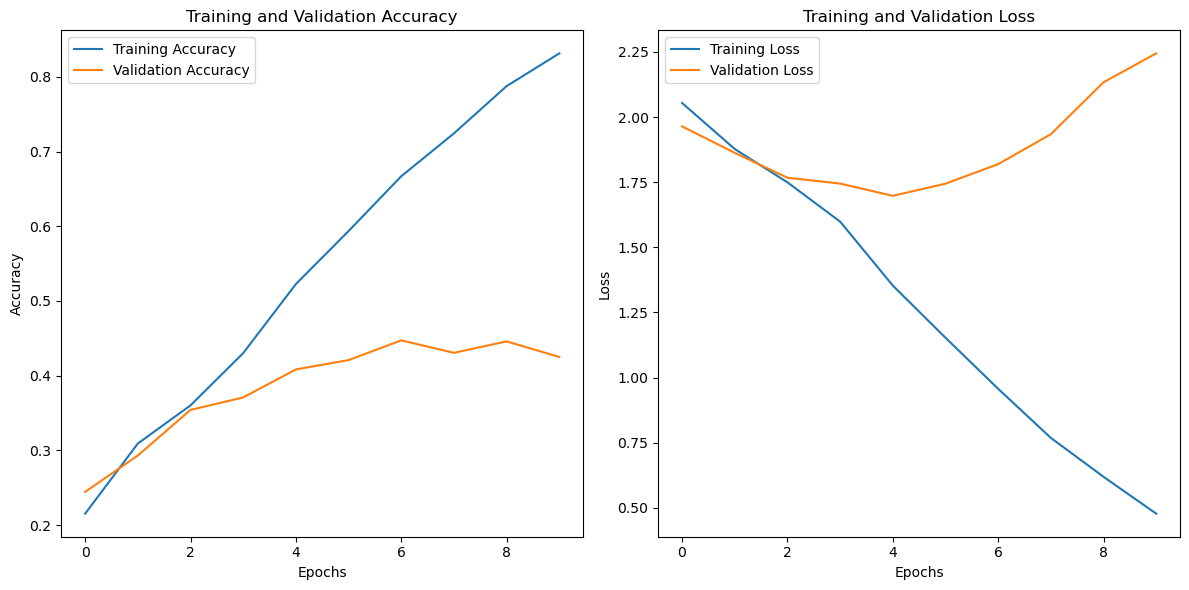

In [371]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


Due to the simple structure of the model, it was able to achieve accuracy of only 45.8%. Also, there is visible case of overfitting in both accuracy and loss.

In the further itterations of the model, the accuracy should increase and overfitting should be be reduced.

## (6.2) Model 2 Implementation (Architectual Changes in the model's layers)

In [391]:
# Model 2 structure
model_2 = Sequential([
    Input(shape=(150, 150, 3)),  # Input layer for RGB images
    
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 5
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    
    # Flatten the feature maps for the fully connected layer
    Flatten(),

    # Additional Hidden Layer
    Dense(128, activation='relu'),
    Dropout(0.7),

    # Output Layer for 8 classes
    Dense(8, activation='softmax')  # Output layer for multi-class classification
])


# Print the summary of Model 2
model_2.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_79 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_79 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_80 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_81 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_82 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_83 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,618,440 (9.99 MB)

 Trainable params: 2,618,376 (9.99 MB)

 Non-trainable params: 64 (256.00 B)

In [383]:
# Compile Model 2
model_2.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [291]:
# Train Model 2
history_2 = model_2.fit(
    X_train, y_train,
    validation_split=0.2,  # 20% of the training data will be used for validation
    epochs=30,             # Train for 30 epochs
    batch_size=32,         # Use a batch size of 32 during training
)


print("Model 2 Training Complete")

# Save Model 2
model_2.save('model_2.keras')

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 719ms/step - accuracy: 0.1407 - loss: 2.2385 - val_accuracy: 0.1736 - val_loss: 2.0729
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 694ms/step - accuracy: 0.2051 - loss: 2.0622 - val_accuracy: 0.2556 - val_loss: 2.0530
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 693ms/step - accuracy: 0.2626 - loss: 1.9678 - val_accuracy: 0.2264 - val_loss: 2.0266
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 699ms/step - accuracy: 0.2813 - loss: 1.9259 - val_accuracy: 0.2403 - val_loss: 1.9795
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 693ms/step - accuracy: 0.2800 - loss: 1.9232 - val_accuracy: 0.2472 - val_loss: 1.9815
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 700ms/step - accuracy: 0.3155 - loss: 1.8409 - val_accuracy: 0.2792 - val_loss: 1.9232
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 694ms/step - accuracy: 0.3047 - loss: 1.8318 - val_accuracy: 0.2806 - val_loss: 1.8583
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 698ms/step - accuracy: 0.3253 - loss: 1.7755 - val_accu

## (7.2) Model 2 Evaluation

In [293]:
# Evaluate model 2 on the test set
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=1)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.4719 - loss: 1.9078
Test Loss: 1.90229070186615
Test Accuracy: 0.4744444489479065


### (8.2) Training Curves for Model 2

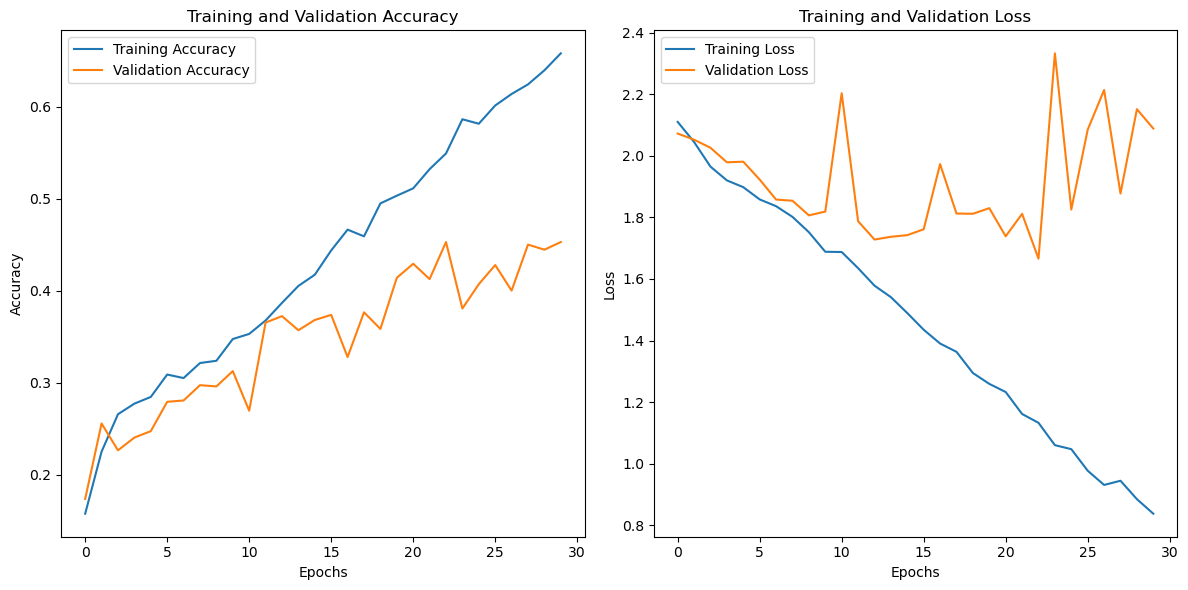

In [295]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In this itteration, the model had an increase of 2 convulution layers, an extra hidden layer, increase in the dropout setting and increase in the number of epochs.

Although overfitting is still present, it has significantly been reduced due to the increase of the dropout setting. In addition, accuracy has improved, but only minimally by around 2% due to the increse in the convulusion and hidden layers. The increase in epochs was required as the new model requires further computation time/itterations to learn using the more complex model structure.

## (6.3) Model 3 Implementation (Architectual Changes in the compilation and training settings)

In [393]:
# Clone model 2 to model 3
model_3 = clone_model(model_2)


# Print the summary of Model 3
model_3.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_79 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_79 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_80 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_81 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_82 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_83 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,618,440 (9.99 MB)

 Trainable params: 2,618,376 (9.99 MB)

 Non-trainable params: 64 (256.00 B)

In [395]:
# Compile Model 3
model_3.compile(
    optimizer=Adam(learning_rate=1e-4),#learning_rate=0.01
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [397]:
# Train Model 3
history_3 = model_3.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64, #batchsize increased to 64
    verbose=1
)

print("Model 3 Training Complete")

# Save Model 3
model_3.save('model_3.keras')

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.1717 - loss: 2.0897 - val_accuracy: 0.1819 - val_loss: 2.0740
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2401 - loss: 2.0105 - val_accuracy: 0.1514 - val_loss: 2.0705
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2575 - loss: 1.9682 - val_accuracy: 0.1903 - val_loss: 2.0544
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2909 - loss: 1.8929 - val_accuracy: 0.2375 - val_loss: 2.0390
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.3013 - loss: 1.8647 - val_accuracy: 0.2653 - val_loss: 2.0232
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2969 - loss: 1.8619 - val_accuracy: 0.3097 - val_loss: 1.9935
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3216 - loss: 1.7905 - val_accuracy: 0.3069 - val_loss: 1.9561
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3294 - loss: 1.7763 - val_accuracy: 0.3042 - val_loss:

## (7.3) Model 3 Evaluation

In [399]:
# Evaluation of model 3
test_loss, test_accuracy = model_3.evaluate(X_test, y_test, verbose=1)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5325 - loss: 1.4342
Test Loss: 1.4020798206329346
Test Accuracy: 0.5400000214576721


### (8.3) Training Curves for Model 3

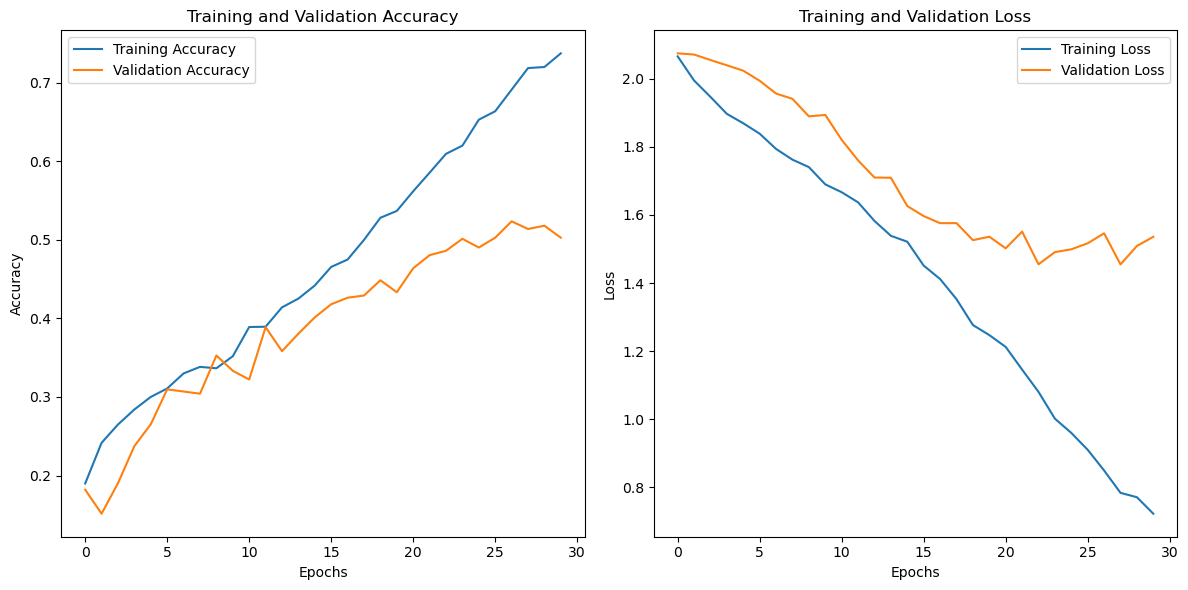

In [401]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In model 3 the learning rate of the Adam optimiser has been changed from 1e - 3 to 1e - 4. This helps the model coverage more gradually and avoid overshooting the optimal solution.

The batch size was increased from 32 to 64. This causes the gradient updates more stable, leading to smoother convergence and allowing the model to make more precise updates. However, there is some risk of overfitting if the model starts to converge too quickly.

In conclusion, with these changes the model's accuracy increased from 47.4% to 54.0%. On the other hand, the model still overfits after reaching 50% accuracy at around 25 epochs.

## (6.4) Model 4 Implementation (Model 3 + Augmentation)

In [225]:
# Augmentation generator using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=45,            # Randomly rotate images in the range 45 degrees
    width_shift_range=0.25,        # Randomly translate images horizontally
    height_shift_range=0.25,       # Randomly translate images vertically
    shear_range=0.25,              # Shear angle in counter-clockwise direction
    zoom_range=0.25,               # Randomly zooming inside pictures
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill missing pixels after transformation
)


# Split the data into training and validation sets with stratification
X_train_aug, X_val, y_train_aug, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


# Fit the ImageDataGenerator on the training data
datagen.fit(X_train_aug)

In [227]:
# Clone Model 3 to create Model 4
model_4 = clone_model(model_3)


# Print summary of Model 4
model_4.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,618,440 (9.99 MB)

 Trainable params: 2,618,376 (9.99 MB)

 Non-trainable params: 64 (256.00 B)

In [229]:
# Compile Model 4
model_4.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Checkpoint to save the best model during training based on validation accuracy
checkpoint = ModelCheckpoint(
    filepath='best_model_4_with_augmentation.keras',  # Filepath to save the model
    monitor='val_accuracy',                          # Monitor validation accuracy
    save_best_only=True,                             # Save only the best model
    mode='max',                                      # Maximize accuracy
    verbose=1                                        # Print save status
)

## (7.4) Model 4 Evaluation

In [231]:
# Train Model 4 using augmented data and manual validation data
history_4 = model_4.fit(
    datagen.flow(X_train_aug, y_train_aug, batch_size=64),  # Use the augmented data
    validation_data=(X_val, y_val),  # Pass the validation data directly
    epochs=150, # increase epochs to 150
    callbacks=[checkpoint], # Use the checkpoint to save the best model based on validation accuracy
    verbose=1
)

print("Model 4 Training Complete")


# Save Model 4
model_4.save('model_4_with_augmentation.keras')

best_model_4 = load_model('best_model_4_with_augmentation.keras')

C:\Users\cbado\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1408 - loss: 2.1047
Epoch 1: val_accuracy improved from -inf to 0.17083, saving model to best_model_4_with_augmentation.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.1408 - loss: 2.1042 - val_accuracy: 0.1708 - val_loss: 2.0757
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1820 - loss: 2.0576
Epoch 2: val_accuracy improved from 0.17083 to 0.24722, saving model to best_model_4_with_augmentation.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1820 - loss: 2.0576 - val_accuracy: 0.2472 - val_loss: 2.0732
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1835 - loss: 2.0560
Epoch 3: val_accuracy improved from 0.24722 to 0.25694, saving model to best_model_4_with_augmentation.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.1835 - loss: 2.0559 - val_accuracy: 0.2569 - val_loss: 2.0686
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2175 - loss: 2.

In [233]:
# Evaluate model 4 
best_test_loss, best_accuracy = best_model_4.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {best_test_loss}")
print(f"Test Accuracy: {best_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.6561 - loss: 1.0317
Test Loss: 1.0284467935562134
Test Accuracy: 0.6433333158493042


### (8.4) Training Curves for Model 4

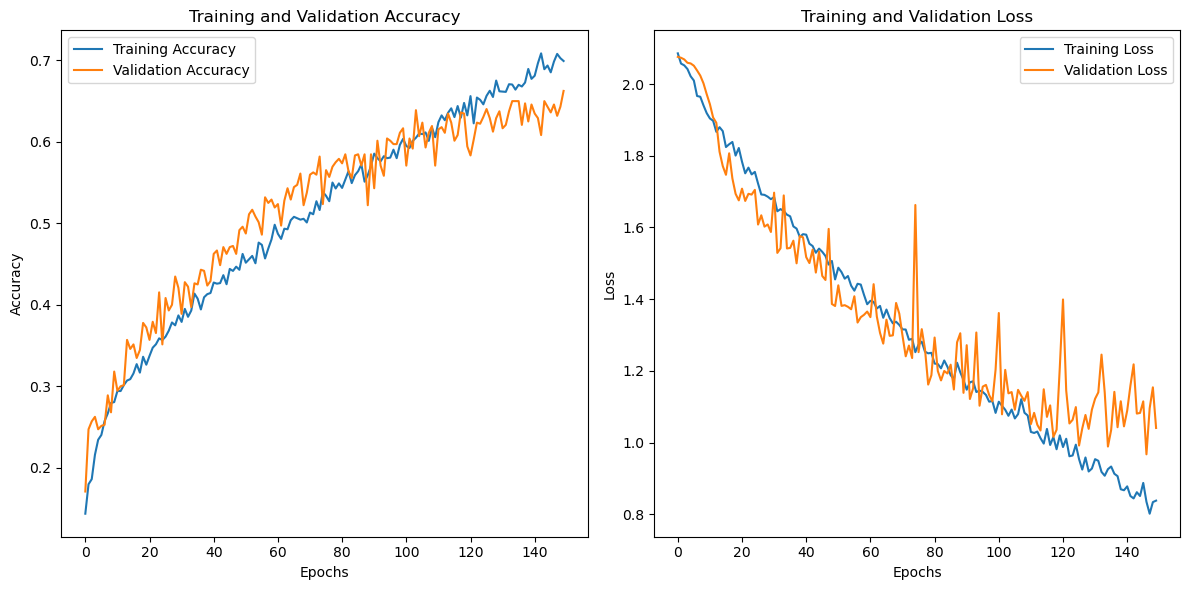

In [235]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Model 4 has the same structure as model 3.

On top of the previous model, model 4 has augmentation and model checkpoint.

Augmentation is the main contributor to the increse in performance.

Image augmentation improves model performance by artificially expanding and diversifying the dataset through transformations yr specific settings include:

- **Rotation Range:** Randomly rotates images up to **45 degrees**, simulating different orientations.
- **Width and Height Shifts:** Translates images up to **25% horizontally** and **vertically**, accounting for positional variations.
- **Shear Range:** Applies a shear transformation up to **25%**, altering image perspective.
- **Zoom Range:** Zooms into images by up to **25%**, mimicking different scales.
- **Horizontal Flip:** Randomly flips images **horizontaimproving thehancing symmetry learning.
- **Fill Mode:** Uses **'nearest'** to handle missing pixels from transformations.
mentation settingsalisation, prevent overfittillng on sma datasets, and improve accuracy by preparing fore mod-wo real-w.ss. ld image  Alsao, the datset size is increased allowing for more modeg.riations.


Model checkpoint ensures that the best performing model by accuracy is saved. Also, overfitting is mitigated by the model being saved before overfitting occures.

In the model training 66.25% was the highest recorded accuracy, but for the testing accuracy it was reduced to 64.3% due to generalisation gap. However, the accuracy and loss didn't show sign of overfitting before 120 epochs, but then the model overfits after 120 epochs.

### 10 Random Images Tested

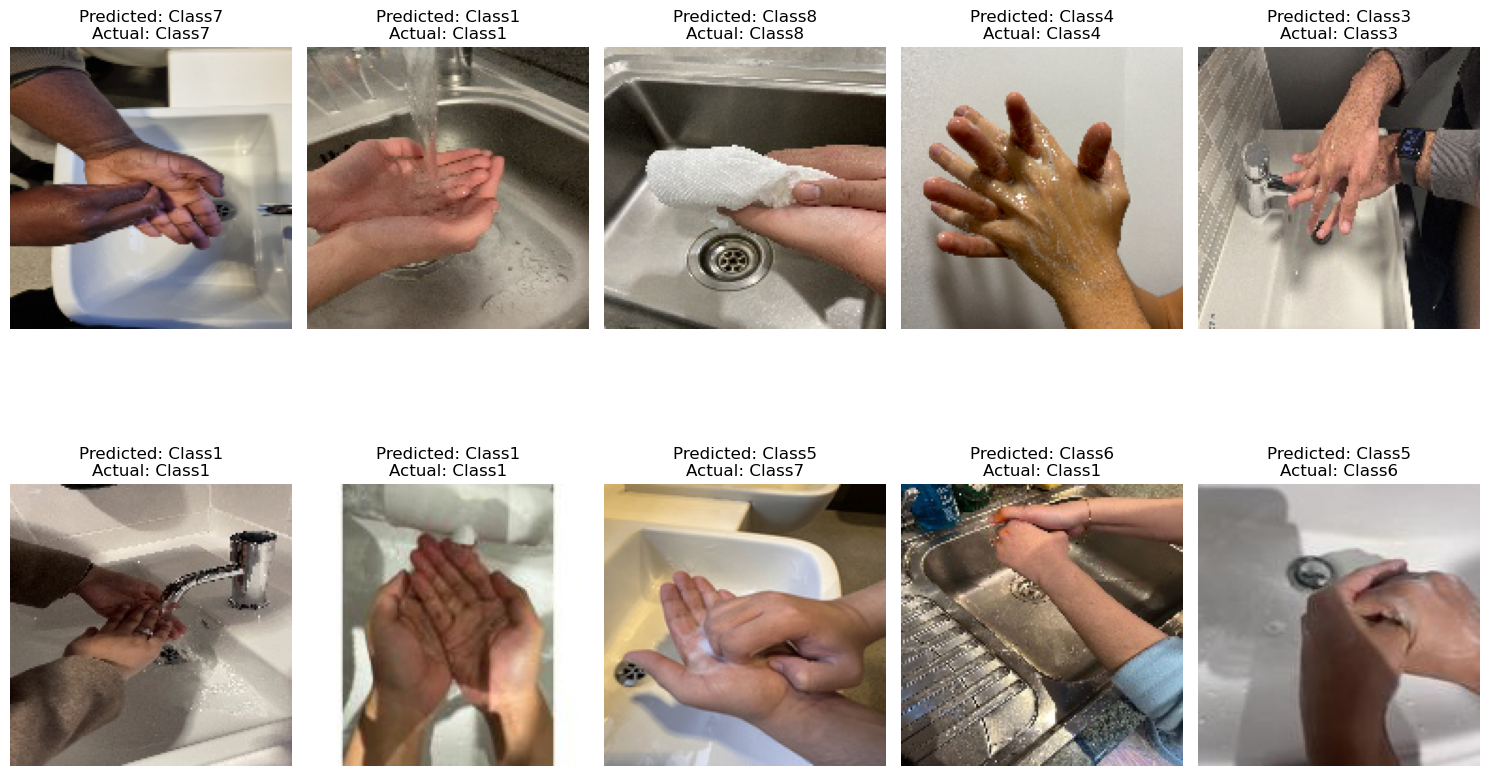

In [350]:
# Map of class indices to class names
class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8']

# Randomly select 10 indices from the test set
random_indices = random.sample(range(len(X_test)), 10)

# Create a subplot for displaying images
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    # Select the image and actual label
    image = X_test[idx]
    actual_label = np.argmax(y_test[idx])
    
    # Add batch dimension for prediction
    image_batch = np.expand_dims(image, axis=0)
    
    # Predict the label using best model 4
    prediction = best_model_4.predict(image_batch, verbose=0)
    predicted_label = np.argmax(prediction)
    
    # Display the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    
    # Show predicted and actual labels
    plt.title(f"Predicted: {class_names[predicted_label]}\nActual: {class_names[actual_label]}")

# Show the plots
plt.tight_layout()
plt.show()


Above are 10 random images selected from the test set and are Stage predicted.

## Final Performance Evaluation

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step
Classification Report:
              precision    recall  f1-score   support

      Class1     0.8589    0.9272    0.8917       151
      Class2     0.5672    0.3800    0.4551       100
      Class3     0.6163    0.5048    0.5550       105
      Class4     0.6222    0.5045    0.5572       111
      Class5     0.5098    0.3562    0.4194        73
      Class6     0.4583    0.7196    0.5600       107
      Class7     0.6160    0.6814    0.6471       113
      Class8     0.7467    0.8000    0.7724       140

    accuracy                         0.6433       900
   macro avg     0.6244    0.6092    0.6072       900
weighted avg     0.6451    0.6433    0.6356       900



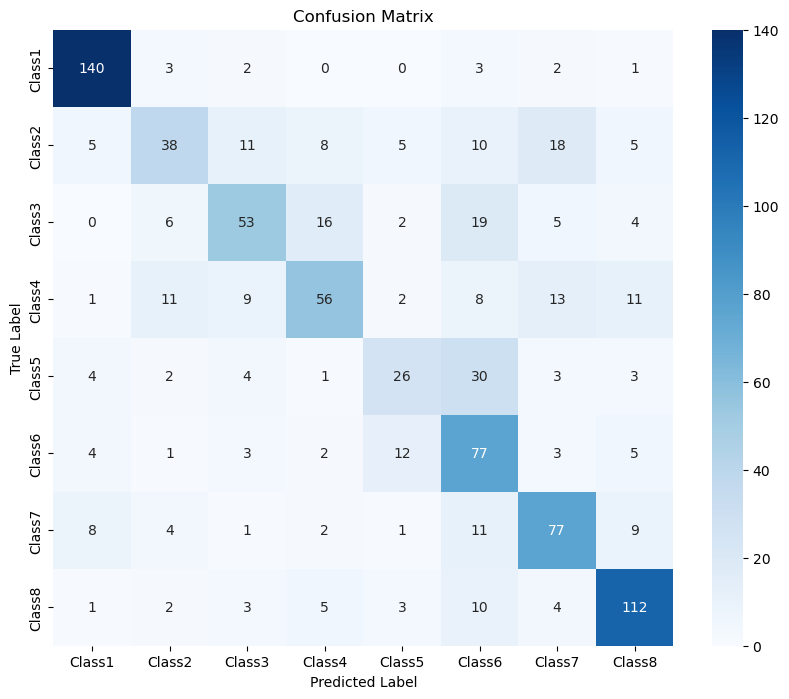

Accuracy: 0.6433
Precision (Weighted): 0.6451
Recall (Weighted): 0.6433
F1-Score (Weighted): 0.6356


In [253]:
# Predict labels for the test set
y_pred_probs = best_model_4.predict(X_test, verbose=1)  # Get probabilities
y_pred = np.argmax(y_pred_probs, axis=1)           # Convert probabilities to class indices
y_true = np.argmax(y_test, axis=1)                 # Get true labels from one-hot encoding

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate overall metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")


As seen in section 8.4, the model starts to overfit at around after 120 epochs/reaching 63%. For the loss, overfitting occures too at 120 epochs. This shows that the model starts to focus too much on the training sets more than the further generalised patterns found in them, that are present in the testing sets.

- **Precision > Recall > F1-Score:**
  - For **classes 1, 6, 7, and 8** (first category), the model is cautious with positive predictions, ensuring fewer false positives but missing some true positives (lower recall).

- **Precision > F1-Score > Recall:**
  - For **classes 2, 3, 4, and 5** (second category), the model still prioritises precision but maintains a better balance between precision and recall, although it still misses some true positives.

There is a correlation with the number of image(support) and the scores(precision, recall and f=1 score). This is further supported by the heatmap above. Class 1 and 2 have the most support meaning that they performed the best. Class 5 and 2 had the least support and it had the worst performance. This is due to the fact that Class 5 and 2 had the least input for the learning model meaning the model couldn't distinguish it from the others well. However, the difference between Class 5 and 2 is that for Class 5 the most predictions were either Class 5 or 6(taking up 56 out of the total 73 Class 5 images). Where as, Class 2 predictions were mostly Class 2, but a fair spread was shared between Classes 3, 6 and 7. This means that the model has great difficulty with identifying patterns that would distinguish Class 2 from every other Class. Class 5 almost succeeds, but it only has difficulty with distinguishing between itself and Class 6 because it hasn't had enough images to learn from. If there would be a higher support for Class 5 then it's accuracy should increase because as seen in Class 6 prediction, the true positive predictions is high (77/107 correct predictions).

The model's performance metrics—Accuracy (0.6433), Precision (Weighted) (0.6451), Recall (Weighted) (0.6433), and F1-Score (Weighted) (0.6356)—are all closely aligned, indicating a balanced and well-performing model. This suggests that the model is not overfitting or underfitting, and is effectively managing both false positives and false negatives. The close similarity between precision, recall, and F1-score is a good sign, but there is still potential for improvement, especially in terms of the F1-score. Overall, the model's performance is reasonable and stable.

For future improvements I would hope to be able to use RGB instead of Grayscale for labelling erros. This could potentially increase the model's performance as RGB structure is used in my model layer structures. Moving on, I would increase the size of the valid dataset, especially for Stage 2. This would give more material for the model to train on, meaning it should potentially improve. In addition, with more time the model's structure and hyperparameters would be changed to further optimise the model's performance. Finally, to reduce overfitting I would perform L2 regulation. This introduces penalty to the loss function, which discourages the model from relying too heavily on any single feature or assigning excessively large weights to certain parameters.